In [9]:
%matplotlib inline
import os
import numpy as np
import hashlib
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pytesseract
import pandas as pd
import cv2

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

/home/sebastianwaisbrot/.local/share/virtualenvs/papersplease-bot-BSZOVR7E/lib/python3.5/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 12] Cannot allocate memory.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [10]:
VIOLATIONS = [
    # entry permit
    'Entry Permit: Invalid Id Number',
    'Entry Permit: Invalid Expiration Date',
    'Entry Permit: Invalid Name',
    'Missing Entry Permit',
    'Forged Entry Permit',

    # passport
    'Missing Passport',
    'Passport: Invalid Gender',
    'Passport: Invalid Expiration Date',
    'Passport: Non-matching photo',
    'Passport: Invalid Issuing City',
    
    # id card
    'Missing Id Card',
    'Id Card: Invalid Birth Date',
    'Id Card: Non-matching photo',
    'Id Card: Invalid Weight',
    'Id Card: Invalid Height',
    'Id Card: Invalid Name',
    'Id Card: Invalid District',

    # id supplement
    'Missing Id Supplement',
    'Id Supplement: Invalid Expiration Date',
    'Id Supplement: Invalid Weight',
    'Id Supplement: Invalid Height',
    'Id Supplement: Invalid Thumbprint',
    'Id Supplement: Invalid Description',

    # responses
    'Incorrect purpose response',
    'Incorrect visit duration response',
    
    # Diplomatic
    'No Diplomatic Access to Arstotzka',
    'Diplomatic Auth: Invalid Name',
    'Diplomatic Auth: Invalid Id Number',
    'Forged Diplomatic Auth',

    # Work pass
    'Missing Work Pass',
    'Work Pass: Invalid Name',
    'Forged Work Pass',
    'Work Pass: Invalid Work End Date',

    # Wanted criminal
    'Wanted criminal admitted',
]

In [11]:
df = pd.concat((
    pd.concat((
        pd.read_csv(os.path.join(root, 'output.csv'), names=VIOLATIONS),
        pd.DataFrame([[os.path.basename(root)]], columns=['id'])
    ), axis=1)
    for root, dirs, files in os.walk('data')
    if 'input.png' in files and 'output.csv' in files
)).set_index('id')
df

,Entry Permit: Invalid Id Number,Entry Permit: Invalid Expiration Date,Entry Permit: Invalid Name,Missing Entry Permit,Forged Entry Permit,Missing Passport,Passport: Invalid Gender,Passport: Invalid Expiration Date,Passport: Non-matching photo,Passport: Invalid Issuing City,...,Incorrect visit duration response,No Diplomatic Access to Arstotzka,Diplomatic Auth: Invalid Name,Diplomatic Auth: Invalid Id Number,Forged Diplomatic Auth,Missing Work Pass,Work Pass: Invalid Name,Forged Work Pass,Work Pass: Invalid Work End Date,Wanted criminal admitted
id,,,,,,,,,,,,,,,,,,,,,
d7bad5ce-5c10-4491-b4e8-65c3e9b91c47,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
eb677b4b-1f4e-4d49-a1a9-be9b64db0917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c0fded9c-edd4-44d4-b14a-05d088889744,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
f1843889-0750-4bed-b3a7-8cc5ff15a881,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c57622ba-1183-4b0a-bc8c-cbe4c7817d22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6bb935f9-754d-4cb3-b643-a6aa2bd543d9,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00a35126-7d0c-4c7b-b0a1-8ee518e0d79c,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46770a21-e41c-4739-8431-f46b7d4fc369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
f57d3e67-1b30-4535-b7c6-fe11cfc5739d,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df['Wanted criminal admitted'].sum(), df.shape[0]

(308, 7705)

In [13]:
df = pd.concat((df[df['Wanted criminal admitted'] == 1], df[df['Wanted criminal admitted'] == 0].sample(n=df['Wanted criminal admitted'].sum())))
df.shape

(616, 34)

In [14]:
X, y = [], []
for id, tag in zip(df.index, df['Wanted criminal admitted']):
    im = Image.open(os.path.join('data', id, 'input.png'))
    out = im.resize([int(0.5 * s) for s in im.size])
    X.append(np.array(out))
    y.append(tag)

In [15]:
X[0].shape

(320, 5387, 3)

In [24]:
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=X[0].shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [25]:
model.fit(np.array(X), y,
          epochs=50,
          batch_size=batch_size,
          validation_split=0.2,
          verbose = 1)

Train on 492 samples, validate on 124 samples
Epoch 1/50
492/492 [==============================] - 1211s 2s/step - loss: 9.8577 - acc: 0.3780 - val_loss: 1.0000e-07 - val_acc: 1.0000
Epoch 2/50
492/492 [==============================] - 1411s 3s/step - loss: 9.8926 - acc: 0.3862 - val_loss: 1.0000e-07 - val_acc: 1.0000
Epoch 3/50
492/492 [==============================] - 1206s 2s/step - loss: 10.1226 - acc: 0.3720 - val_loss: 1.0000e-07 - val_acc: 1.0000
Epoch 4/50
492/492 [==============================] - 1515s 3s/step - loss: 10.0902 - acc: 0.3740 - val_loss: 1.0000e-07 - val_acc: 1.0000
Epoch 5/50
492/492 [==============================] - 1234s 3s/step - loss: 10.0902 - acc: 0.3740 - val_loss: 1.0000e-07 - val_acc: 1.0000
Epoch 6/50
492/492 [==============================] - 1314s 3s/step - loss: 10.0902 - acc: 0.3740 - val_loss: 1.0000e-07 - val_acc: 1.0000
Epoch 7/50
492/492 [==============================] - 1274s 3s/step - loss: 10.0574 - acc: 0.3760 - val_loss: 1.0000e-07 -

In [27]:
model.save('wanted-criminals1')

In [3]:
from keras.models import load_model
model = load_model('wanted-criminals1')

In [16]:
model.predict(X[0])

ValueError: Error when checking input: expected conv2d_4_input to have 4 dimensions, but got array with shape (320, 5387, 3)

In [8]:
# https://github.com/gabrieldemarmiesse/heatmaps

from heatmap import to_heatmap, synset_to_dfs_ids

def display_heatmap(new_model, img, ids, preprocessing=None):
    # The quality is reduced.
    # If you have more than 8GB of RAM, you can try to increase it.
    img = image.load_img(img_path, target_size=(320, 5387))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    if preprocessing is not None:
        x = preprocess_input(x)

    out = new_model.predict(x)

    heatmap = out[0]  # Removing batch axis.

    if K.image_data_format() == 'channels_first':
        heatmap = heatmap[ids]
        if heatmap.ndim == 3:
            heatmap = np.sum(heatmap, axis=0)
    else:
        heatmap = heatmap[:, :, ids]
        if heatmap.ndim == 3:
            heatmap = np.sum(heatmap, axis=2)

    plt.imshow(heatmap, interpolation="none")
    plt.show()
    
new_model = to_heatmap(model, input_shape=(320, 5387, 3))
display_heatmap(new_model, os.path.join('data', df.index[0], 'input.png'), ids, preprocess_input)

Model type detected: local pooling - flatten
Model cut at layer: 9
Pool size infered: 671


ValueError: cannot reshape array of size 104439808 into shape (671,671,64,64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


InvalidArgumentError: Tensor conv2d_4_input:0, specified in either feed_devices or fetch_devices was not found in the Graph

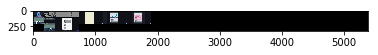

In [68]:
# https://github.com/nickbiso/Keras-Class-Activation-Map/blob/master/Class%20Activation%20Map(CAM).ipynb

def cam(img_path):
    global model2
    model = model2
    import matplotlib.image as mpimg
    from keras import backend as K
    import matplotlib.pyplot as plt
    import cv2
    # K.clear_session()
    
    img = mpimg.imread(img_path)
    img = cv2.resize(img, dsize=tuple((int(0.5 * s) for s in img.T.shape[1:])), interpolation=cv2.INTER_CUBIC)
    plt.imshow(img)
    from keras.preprocessing import image
    #img = image.load_img(img_path, target_size=img.shape)
    #x = image.img_to_array(img)
    # x = np.expand_dims(x, axis=0)
    preds = model.predict(np.array([img]))
    predictions = pd.DataFrame(decode_predictions(preds, top=3)[0],columns=['col1','category','probability']).iloc[:,1:]
    argmax = np.argmax(preds[0])
    output = model.output[:, argmax]
    last_conv_layer = model.get_layer('block5_conv3')
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    hif = .8
    superimposed_img = heatmap * hif + img
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title(predictions.loc[0,'category'].upper())
    return None

import tensorflow
session = tensorflow.Session()
with session.as_default():
    with session.graph.as_default():
        cam(os.path.join('data', df.index[0], 'input.png'))